In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np
import pyreadstat

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [3]:
dfs, metadata = [], []
for file in os.listdir(os.path.join(DATA_DIR, 'hhs')):
    try:

#         dta, metad = pyreadstat.read_dta(os.path.join(DATA_DIR, 'hhs', file), encoding='UTF-8')
        dta = pd.read_stata(os.path.join(DATA_DIR, 'hhs', file))
        dfs.append(dta)
        metadata.append(metadata)
    except Exception as e:
        print(e)
        continue

C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_24148\1666158541.py:6: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dta = pd.read_stata(os.path.join(DATA_DIR, 'hhs', file))


'utf-8' codec can't decode byte 0xfc in position 8: invalid start byte
'utf-8' codec can't decode byte 0x80 in position 5: invalid start byte


C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_24148\1666158541.py:6: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dta = pd.read_stata(os.path.join(DATA_DIR, 'hhs', file))
C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_24148\1666158541.py:6: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dta = pd.read_stata(os.path.join(DATA_DIR, 'hhs', file))
C:\Users\LukasGrahl\AppData\Local\Temp\ipykernel_24148\1666158541.py:6: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-

In [4]:
# obtain inflation expectation

In [5]:
data = pd.concat(dfs, axis=0)

In [14]:
dict_cols_parse = {
    'id': float,
#     'date': 'datetime64[ns]',
    'year': int,
    'month': int,
    'day': int,
    'inflexppoint': float    
}
dict_cols_parse.update({f'infexprob_{i}': str for i in list(map(chr, range(97, 107)))})

_ = [
        "don't know",
        'no answer',
        'does not apply',
    ]
dict_parse_nan = dict(zip(_, list([np.nan]) * len(_)))

In [7]:
df = data[dict_cols_parse.keys()].copy()

In [8]:
del data, dfs

In [9]:
df['date'] = df[['year', 'month', 'day']].apply(lambda x: datetime(*x.astype(int)), axis=1).rename('date').values

In [16]:
df['inflexppoint'] = df['inflexppoint'].apply(lambda x: dict_parse_nan[x] if x in dict_parse_nan.keys() else x)

In [17]:
df = df.astype(dict_cols_parse)

In [18]:
df = df.loc[df.inflexppoint.dropna().index]

In [25]:
# plot

In [40]:
infl = pd.read_csv(os.path.join(DATA_DIR, 'de_inf_prepro.csv'))
infl['date'] = infl['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
infl['year'] = infl.date.apply(lambda x: x.year)
infl['month'] = infl.date.apply(lambda x: x.month)
infl.set_index('date', inplace=True)


In [27]:
df = df[df.inflexppoint <= 10]

In [28]:
df.sort_values(['year', 'month'], inplace=True)

In [30]:
df['year_month'] = df.year.astype(str) + '_' + df.month.astype(str)

In [41]:
infl['year_month'] = infl.year.astype(str) + '_' + infl.month.astype(str)

In [53]:
df = df[df.date > datetime(2020,4,1)]

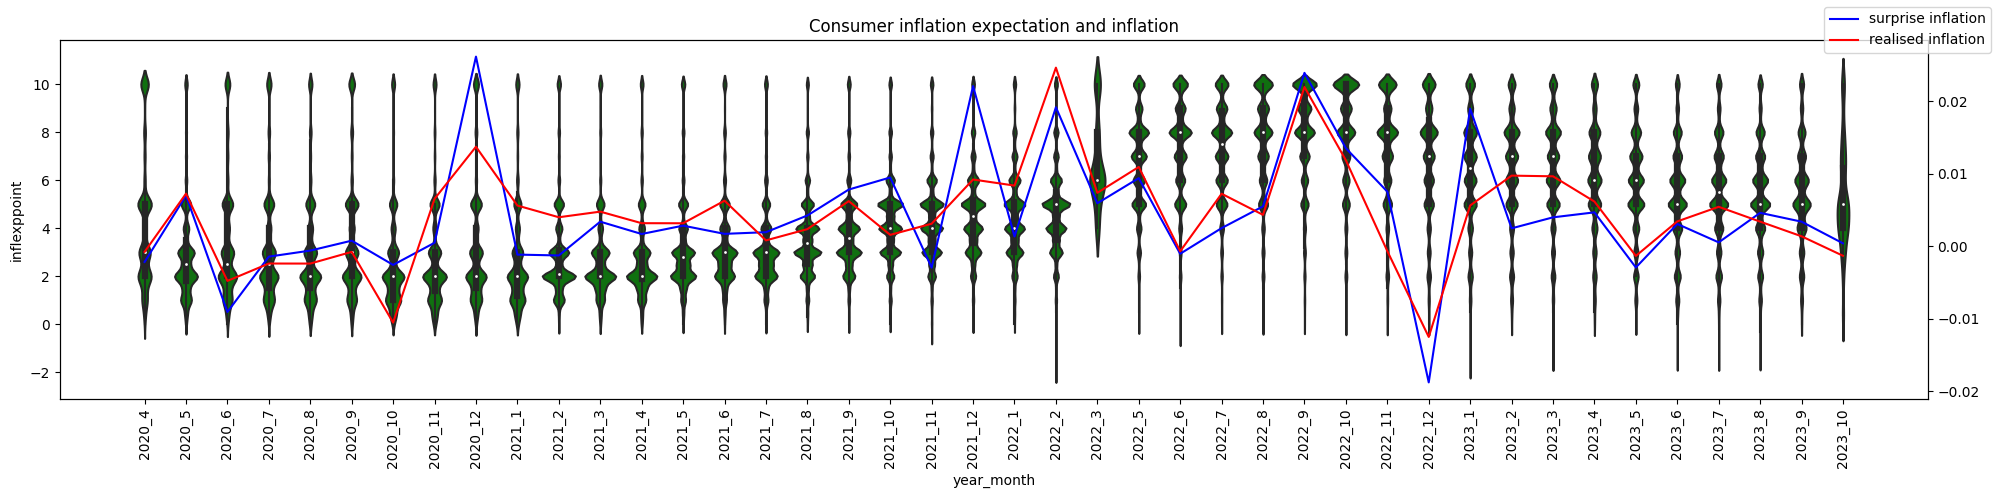

In [54]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
sns.violinplot(data=df, x='year_month', y='inflexppoint', ax=ax, color='green', alpha=.5, label='consumer infl. expect.')
ax2 = ax.twinx()
ax2.plot(infl.loc[df.date.min(): df.date.max()].set_index('year_month').resid, color='blue', label='surprise inflation')
ax2.plot(infl.loc[df.date.min(): df.date.max()].set_index('year_month').pi_de, color='red', label='realised inflation')

ax.tick_params(axis='x', rotation=90)
fig.legend()
plt.title('Consumer inflation expectation and inflation')

plt.tight_layout()

fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph3.png'))

In [127]:
inlf_lag = infl.set_index('year_month').copy()

In [128]:
infl_lag = pd.concat([inlf_lag['resid'].shift(i).rename(f'pi_surp_lag{i}') for i in range(0, 11)], axis=1).dropna()

In [129]:
_ = df.groupby('year_month').inflexppoint.mean() / 100

In [130]:
infl_lag = infl_lag.join(_).dropna()

In [131]:
from statsmodels.regression.linear_model import OLS

In [132]:
ols = OLS(infl_lag['inflexppoint'], infl_lag.drop('inflexppoint', axis=1)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           inflexppoint   R-squared (uncentered):                   0.838
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              14.63
Date:                Tue, 23 Jan 2024   Prob (F-statistic):                    2.28e-09
Time:                        17:42:32   Log-Likelihood:                          103.54
No. Observations:                  42   AIC:                                     -185.1
Df Residuals:                      31   BIC:                                     -166.0
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
pi_surp_lag0      0.7517      0.465      1.616      0.116      -0.197       1.701
pi_surp_lag1      0.9008      0.474      1.899      0.067      -0.067       1.868
pi_surp_lag2      0.8576      0.459      1.867      0.071      -0.079       1.794
pi_surp_lag3      0.9386      0.492      1.908      0.066      -0.065       1.942
pi_surp_lag4      1.0037      0.461      2.177      0.037       0.063       1.944
pi_surp_lag5      1.0250      0.468      2.192      0.036       0.071       1.979
pi_surp_lag6      1.1066      0.468      2.366      0.024       0.153       2.060
pi_surp_lag7      1.0452      0.465      2.247      0.032       0.096       1.994
pi_surp_lag8      0.9034      0.465      1.943      0.061      -0.045       1.852
pi_surp_lag9      0.7960      0.463      1.719      0.096      -0.148       1.740
pi_surp_lag10     0.4030      0.494      0.816      0.420      -0.604       1.410
==============================================================================
Omnibus:                        5.252   Durbin-Watson:                   0.157
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                3.531
Skew:                           0.546   Prob(JB):                        0.171
Kurtosis:                       2.091   Cond. No.                         2.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

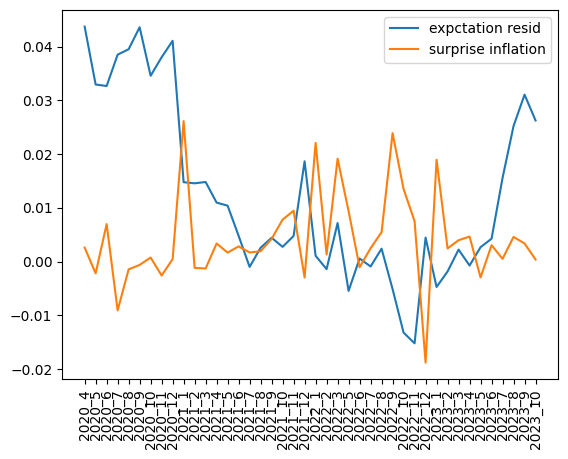

In [133]:
plt.plot(ols.resid)
plt.plot(infl_lag['pi_surp_lag0'])
plt.legend(['expctation resid', 'surprise inflation'])
plt.xticks(rotation=90);